In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from typing import Callable, Tuple

# Optimization with SciPy

## What is optimization?

- Problem
- Constraints
- Objective function
- Gradient
- Problem type
- Dimensionality

## Have we done optimization already?

1. Classic example: Least-squares linear regression

## Example problem

What is the maximal rectangle area's length/height that can fit within a parabola?  Let a = -1, b = 7, c = 4 for the parabola.

Variable names for the rectangle: l for length, h for height, origin_x, origin_y for the bottom-left origin of the rectangle.

In [9]:
def f_parabola(x: np.ndarray, a: float, b: float, c: float) -> np.ndarray:
    return a * np.square(x) + b * x + c

def quadratic_roots(a: float, b: float, c: float) -> Tuple[float, float]:
    root0 = (-b + np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)
    root1 = (-b - np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)
    return root0, root1

def rect_area(x: np.ndarray, a: float, b: float, c: float) -> np.ndarray:
    height = f_parabola(x, a, b, c)
    root0, root1 = quadratic_roots(a, b, c)
    # length = (root1 - x) - (x - root0)
    length = (root1 - root0) + 2 * root0 - 2 * x
    return np.abs(length * height)

def obj_rect_area(x: np.ndarray, a: float, b: float, c: float) -> np.ndarray:
    return -1. * rect_area(x, a, b, c)

In [6]:
parab_xmin, parab_xmax = quadratic_roots(-1, 7, 4)
print(parab_xmin, parab_xmax)
print((parab_xmax - parab_xmin) / 2 + parab_xmin)
print(rect_area(3.5, -1, 7, 4))

-0.5311288741492746 7.531128874149275
3.5
0.0


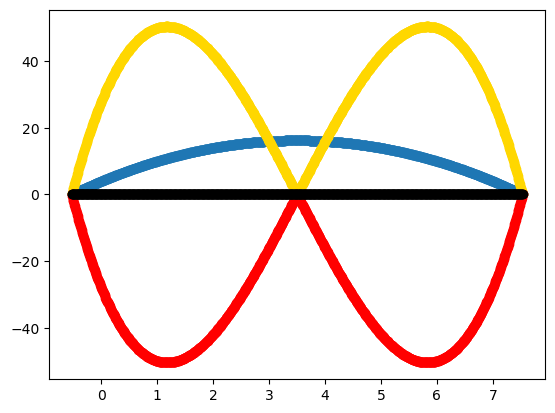

In [10]:
parab_x = np.linspace(start=parab_xmin, stop=parab_xmax, num=1000)
parab_y = f_parabola(parab_x, -1, 7, 4)
the_rectarea = rect_area(parab_x, -1, 7, 4)
the_obj_rectarea = obj_rect_area(parab_x, -1, 7, 4)

plt.scatter(parab_x, parab_y)
plt.scatter(parab_x, the_rectarea, c="gold")
plt.scatter(parab_x, the_obj_rectarea, c="red")
plt.scatter(parab_x, np.zeros_like(parab_x), c="black")

### Minimization for smooth functions

In [15]:
scipy.optimize.minimize_scalar(obj_rect_area, args=(-1, 7, 4))

     fun: -50.42642238027673
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 14
     nit: 10
 success: True
       x: 1.1726266421540226

In [14]:
scipy.optimize.minimize_scalar(obj_rect_area, method='bounded', bounds=(3, 8), args=(-1, 7, 4))

     fun: -50.42642238024738
 message: 'Solution found.'
    nfev: 10
     nit: 10
  status: 0
 success: True
       x: 5.827374789821771

This is "bad" because it is a non-differentiable function, so any derivatives that we calculate cannot be guaranteed to be correct:

In [37]:
def bad_obj_rect_area(x: np.ndarray, a: float, b: float, c: float) -> np.ndarray:
    if np.round(x, 1) != 3.4:
        return -1. * rect_area(x, a, b, c)
    else:
        return -9001.

In [38]:
scipy.optimize.minimize_scalar(bad_obj_rect_area, method='bounded', bounds=(3, 4), args=(-1, 7, 4))

     fun: -9001.0
 message: 'Solution found.'
    nfev: 22
     nit: 22
  status: 0
 success: True
       x: 3.38197232059872

### "Global" minimization methods (for not-so-smooth functions)

In [39]:
scipy.optimize.basinhopping(obj_rect_area, x0=0.0, minimizer_kwargs={"args": (-1, 7, 4)})

                        fun: -50.42642238027674
 lowest_optimization_result:       fun: -50.42642238027674
 hess_inv: array([[0.03582084]])
      jac: array([4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 10
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([1.17262665])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 956
                        nit: 100
                       njev: 478
                    success: True
                          x: array([1.17262665])

In [42]:
scipy.optimize.dual_annealing(bad_obj_rect_area, bounds=[(-10, 10)], args=(-1, 7, 4))

     fun: -9001.0
 message: ['Maximum number of iteration reached']
    nfev: 2007
    nhev: 0
     nit: 1000
    njev: 3
  status: 0
 success: True
       x: array([3.35282184])

### Trying to make a voltage divider the lazy way

Let's say that we've got a 3.3 V source and we have two sets of real, physically-obtainable resistors, and we want to get to an output voltage of 1.8 V.

Let's say that our real resistors are in the set: [100, 220, 330, 470, 560, 680, 1000, 2200, 4700, 5600, 6800]

In [15]:
def round_ten(x):
    return int(np.ceil(x / 10.0)) * 10

def lazy_obj_voltage_divider(x: np.ndarray, v_in: float, v_out: float, r_set: list) -> float:
    """
    :param x: a 1x2 vector where x[0] is R1 and x[1] is R2; R2 is the resistor to ground.
    """
    R1 = x[0]
    R2 = x[1]
    if round_ten(R1) not in r_set or round_ten(R2) not in r_set:
        return 9001
    guess_V_out = v_in * (R2 / (R1 + R2))    
    return np.abs(v_out - guess_V_out)  # NOTE: we had a mistake earlier and wrote v_in instead of v_out

In [23]:
scipy.optimize.dual_annealing(
    lazy_obj_voltage_divider, 
    bounds=[(100, 10000), (100, 10000)], 
    args=(3.3, 1.8, [100, 220, 330, 470, 560, 680, 1000, 2200, 4700, 5600, 6800]),
    maxiter=10000,
    seed=7
)

     fun: 1.2656542480726785e-14
 message: ['Maximum number of iteration reached']
    nfev: 191788
    nhev: 0
     nit: 10000
    njev: 50593
  status: 0
 success: True
       x: array([462.60749943, 555.12899932])